In [76]:
import rosbag_pandas
import pandas as pd
import numpy as np

width = 6
height = 0.382 / 0.618 * width
fontsize = 12

file = '2020-07-29-13-37-12.bag'
# Open file
df = rosbag_pandas.bag_to_dataframe(file)
#rosbag record /versavis_old/ext_event /moa/time_sync /moa/piksi/attitude_receiver_0/ros/ext_event /moa/bfly/header /moa/adis16448bmlz/imu/temp

In [66]:
# Time stamps to seconds.    
df_piksi = pd.to_datetime(df['/moa/piksi/attitude_receiver_0/ros/ext_event/stamp/data/secs'], unit='s') + pd.to_timedelta(df['/moa/piksi/attitude_receiver_0/ros/ext_event/stamp/data/nsecs'], unit='ns')
df_ours = pd.to_datetime(df['/moa/bfly/header/stamp/secs'], unit='s') + pd.to_timedelta(df['/moa/bfly/header/stamp/nsecs'], unit='ns') 
df_theirs = pd.to_datetime(df['/versavis_old/ext_event/data/secs'], unit='s') + pd.to_timedelta(df['/versavis_old/ext_event/data/nsecs'], unit='ns') 

# To datetime.
df_piksi = df_piksi.reset_index()
df_piksi.columns = ['t_arrival', 't_piksi']
df_piksi['t_arrival'] = pd.to_datetime(df_piksi['t_arrival'], unit='s')
df_piksi.dropna(inplace=True)

df_ours = df_ours.reset_index()
df_ours.columns = ['t_arrival', 't_ours']
df_ours['t_arrival'] = pd.to_datetime(df_ours['t_arrival'], unit='s')
df_ours.dropna(inplace=True)

df_theirs = df_theirs.reset_index()
df_theirs.columns = ['t_arrival', 't_theirs']
df_theirs['t_arrival'] = pd.to_datetime(df_theirs['t_arrival'], unit='s')
df_theirs.dropna(inplace=True)

# Find nearest arrival time pairs.
df_our_pairs = pd.merge_asof(df_piksi, df_ours, on='t_arrival', tolerance=pd.Timedelta(milliseconds=100), direction='nearest')
df_our_pairs.dropna(inplace=True)

df_their_pairs = pd.merge_asof(df_piksi, df_theirs, on='t_arrival', tolerance=pd.Timedelta(milliseconds=100), direction='nearest')
df_their_pairs.dropna(inplace=True)

# Calculate error.
df_our_diff = df_our_pairs[['t_piksi', 't_ours']].diff(axis=1)
df_our_diff = df_our_diff.loc[df_our_diff['t_ours'] > -pd.Timedelta('1 second')] # Filter obvious wrong times
df_our_error = pd.concat([df_our_pairs['t_piksi'], df_our_diff['t_ours']], axis=1, sort=True)
df_our_error.columns = ['t', 'ours']
df_our_error = df_our_error.set_index('t')

df_their_diff = df_their_pairs[['t_piksi', 't_theirs']].diff(axis=1)
df_their_error = pd.concat([df_their_pairs['t_piksi'], df_their_diff['t_theirs']], axis=1, sort=True)
df_their_error.columns = ['t', 'theirs']
df_their_error = df_their_error.set_index('t')

# Reindex to start from the first recorded second.
t0 = df_our_error.index[0]
t0 = t0.replace(nanosecond=0)
t0 = t0.replace(microsecond=0)
df_our_error.index = df_our_error.index - t0

t0 = df_their_error.index[0]
t0 = t0.replace(nanosecond=0)
t0 = t0.replace(microsecond=0)
df_their_error.index = df_their_error.index - t0

# Convert to index to seconds and value to s.   
import numpy as np
df_our_error['ours'] = df_our_error['ours'] / np.timedelta64(1,'s')
df_our_error.reset_index(inplace=True)
df_our_error['t'] = df_our_error['t'] / np.timedelta64(1, 's')

df_their_error['theirs'] = df_their_error['theirs'] / np.timedelta64(1,'s')
df_their_error.reset_index(inplace=True)
df_their_error['t'] = df_their_error['t'] / np.timedelta64(1, 's')



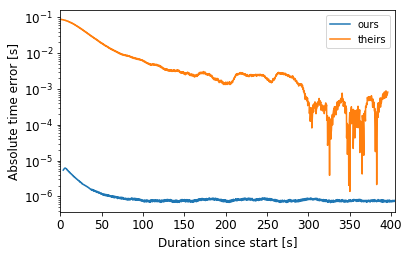

In [77]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(width,height))

df_our_error.abs().plot(ax=ax, x='t', fontsize=fontsize, logy=True)
df_their_error.abs().plot(ax=ax, x='t', fontsize=fontsize, logy=True)

ax.set_xlabel('Duration since start [s]', fontsize=fontsize)
ax.set_ylabel('Absolute time error [s]', fontsize=fontsize)

ax.get_figure().savefig("plots/error.pdf", bbox_inches='tight')

In [83]:
# Compute statistics
print("Ours, mean, std")
print(df_our_error.loc[df_our_error['t'] > 100]['ours'].mean()) * 10**6
print(df_our_error.loc[df_our_error['t'] > 100]['ours'].std()) * 10**6

print("Theirs, mean, std")
print(df_their_error.loc[df_their_error['t'] > 300]['theirs'].mean()) * 10**6
print(df_their_error.loc[df_their_error['t'] > 300]['theirs'].std()) * 10**6

Ours, mean, std
-0.7758891803278689
0.049061321848203915
Theirs, mean, std
179.40693541666664
311.52099043875614


In [85]:
311/0.05


6220.0